# Personal Signature Detector: A machine learning handwritten signature classifier

Signature recognition is another example task where Machine and Deep Learning has shined in recent years, however the different challenges involved in detection and classification of the variety types of signatures it’s also a relatively new and unexplored field. The present project tries to contribute to this research area by training a simple model in a signature’s dataset.

Specifically our goal is to train a model capable of identifying an image of a particular signature from a group of different signature images. For that we generated a set of 160 handwritten signature images: 80 drawings of a fake signature of interest, and 80 drawings of different fake signatures. 

For this step it was taken into account the use of different papers, pen colours, backgrounds, ink thickness and image sizes. Then we generated a function capable of taking the images as input and populate a dataframe labeling 1 for the signature of interest and 0 for the others, transforming all these images in a flatten array format and perform preprocessing work for machine learning purposes, giving as output a matrix features ready for training. 

As a final step we applied regularization, principal components segmentation, split the data into training and test sets, and performed cross validation tests in the next models: knn, logistic regression, decision tree classifier, support vector machine and random forest. The model that achieved the best performance was the logistic regression classifier with an accuracy of 0.85


## 1. Libraries and data

This project was developed in Python, the libraries used are shown below.

In [1]:
# General purpose packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint

# Image processing packages
from skimage import io, color
from skimage.transform import resize
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage.filters import try_all_threshold, sobel
from skimage import exposure

# Preprocessing modeling packages
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Modeling packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import VotingClassifier

# Test metrics packages
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, mean_squared_error as MSE, classification_report


In the directory it is included: 160 .jpeg images of fake signature handwritten drawings, half of them refers to our target signature and the other half to signatures that we want to differentiate from. Every image refers to a unique draw, so even in the target ones it is always considered some sort of variation in the draw lines, as it is in real life signatures. It had also been taken in consideration to include four types of ink color: black, blue, red and pencil; different types of backgrounds: clean, with lines, with dots, squared; different types of thickness in the writing and different illuminations. 

Next, we define a function that takes as input a row id from the data frame, searches for a .jpeg image with the same name in the directory, reads it, resizes it and returns it as a numpy array. Results can also be checked by giving the image row of two signatures. In the directory it is also included a csv file with the images names and labels. 

With the next lines of code we can open and inspect  the csv file as a data frame.

In [2]:
df = pd.read_csv('signatures_data.csv', index_col=0) # Open the data frame with first column as index
print(df.head())
print(df.shape)

       label
Id          
0_001      0
0_002      0
0_003      0
0_004      0
0_005      0
(160, 1)


## 2. Functions

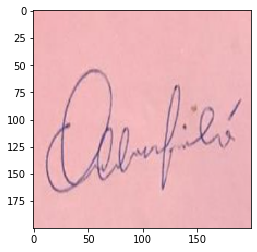

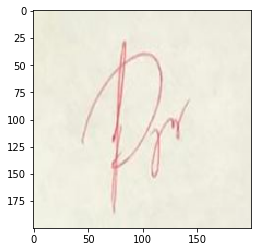

In [3]:
# FUNCTION 1

def get_image(row_id):
    filename = "{}.jpeg".format(row_id)
    img = io.imread(filename)
    img = resize(img, (200,200), anti_aliasing=True) # resize image
    return np.array(img)

# Check the function in the first cat image and the first dog image

other_1_row = df[df["label"] == 0].index[0]
other_1 = get_image(other_1_row)
other_1.shape
plt.imshow(other_1)
plt.show()

personal_10_row = df[df["label"] == 1].index[9]
personal_10 = get_image(personal_10_row)
personal_10.shape
plt.imshow(personal_10)
plt.show()

So now we could transform an image file into a numeric format capable of being processed by Python, but we can make more transformations in order to improve our future model. All images are RGB type, this is color images, but as we want that our model classifies correctly signatures despites the color of the ink or the background, we are going to use a rgb to gray function to transform all them to grayscale. The pictures aren’t anymore in three channels and 200 x 200 size (200, 200, 3), they are changed to the same size but one channel (200, 200, 1). 

Let’s inspect the changes in the same two pictures.

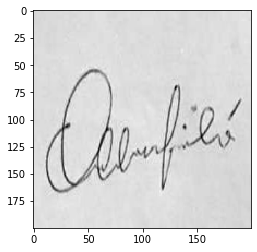

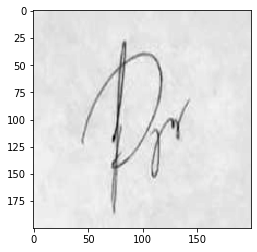

In [4]:
# Inspect converting to grayscale

other_1_grey = color.rgb2gray(other_1)
plt.imshow(other_1_grey, cmap=plt.cm.gray)
plt.show()

personal_10_grey = color.rgb2gray(personal_10)
plt.imshow(personal_10_grey, cmap=plt.cm.gray)
plt.show()

As a second transformation method, we are going to apply an edge detection sobel function. Edge detection is a key step in image processing algorithms as it has remarkable capabilities of differentiate structures shapes, likewise the sobel edge detection method is one of the most versatile ones. In the next lines of code we can also inspect these transformations for the same images.

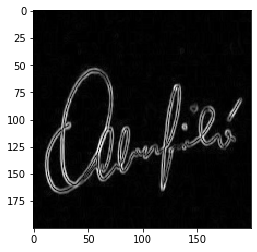

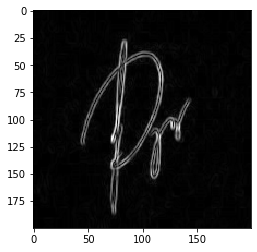

In [5]:
# Apply edge detection

other_1_sobel = sobel(other_1_grey)
plt.imshow(other_1_sobel, cmap=plt.cm.gray)
plt.show()

personal_10_sobel = sobel(personal_10_grey)
plt.imshow(personal_10_sobel, cmap=plt.cm.gray)
plt.show()

Next we are going to generate a function that grabs all the features of one RGB resized image (generated as “img” by the function 1) and all the features of it corresponded sobel edge detection image, then it flattens all features together into one single array called “flat_features”.

In [6]:
# FUNCTION 2
def create_features(img):
    # 0. flatten all features of the RGB image
    # color_features = img.flatten()
    # 1. convert image to grayscale
    grey_image = color.rgb2gray(img)
    # 2. get the grey features
    grey_features = grey_image.flatten() 
    # 3. get the sobel features from the grayscale image
    sobel_features = sobel(grey_image).flatten()
    # 4. combine the RGB and the HOG features into a single array
    flat_features = np.hstack((grey_features, sobel_features))

    return flat_features

# Check the function in the first image
other_1_features = create_features(other_1)
other_1_features.shape

(80000,)

Finally we generate now a function 3 that combines the functions 1 and 2 and can be applied to all the images in the directory. So the next function takes every row index name of the data set and for each one applies functions 1 and 2, then appends each features array to an empty list and finally transform the populated list into an array, returning a matrix of the features that has in each row an image and in each column a feature.

In [7]:
# FUNCTION 3
def create_feature_matrix(label_dataframe):
    feature_list = []

    for img_id in label_dataframe.index:
        # 1. Apply function 1 (convert image to array)
        img = get_image(img_id)
        # 2. Apply function 2 (generate features and stack them)
        img_features = create_features(img)
        # 3. Append img features to the empty list
        feature_list.append(img_features)

    # Convert the list of arrays into an array matrix
    feature_matrix = np.array(feature_list)

    return feature_matrix

If we apply the function to the data frame in the directory, we can then inspect the results and shape of our data frame ready for machine learning. Remember that all the images must be in the directory.

In [10]:
features_matrix = create_feature_matrix(df)

type(features_matrix)
features_matrix.shape # 80 thousand columns each one row!! that´s big data for sure!

print(features_matrix[0].shape)
print(features_matrix[19].shape)
print(features_matrix[28].shape)
print(features_matrix[31].shape)

(80000,)
(80000,)
(80000,)
(80000,)


## 3. Modeling

As many machine learning models perform best with standardized data (mean of 0 and a scaling unit variance) we need to apply some kind of standar scaler to the dataframe before processing. Also, detecting clusters of features that highly correlate with each other is important to group them into one dimension, this step is recommended to reduce the number of features as it tends to improve machine learning performance. To do so, we applied a Standard Scaler function and Principal Component Analysis (PCA).

In [11]:
ss = StandardScaler() # Standardize features by removing the mean and scaling to unit variance
stand_matrix = ss.fit_transform(features_matrix)

pca = PCA(n_components = 160) # reduce to 40 features
pca_matrix = pca.fit_transform(stand_matrix)

pca_matrix.shape

(160, 160)

Then we proceed with the classical “train test split” method from Scikit-Learn to divide our data into a training set in which we are going to adjust our models, and a test set unseen to the models to evaluate their performances.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(pca_matrix,
                                                    df.label.values,
                                                    test_size = .3,
                                                    random_state = 123)

# Check the split
pd.Series(y_train).value_counts()
pd.Series(y_test).value_counts()

0    25
1    23
dtype: int64

As this is a binomial classification problem we are training the data with five classical machine learning models: k nearest neighbor classifier, logistic regression, decision tree classifier, support vector machine classifier and random forest classifier. To prevent overfitting issues and improve accuracy, we are also applying 5 fold cross validation and the corresponding hyperparameter tuning to every model.

In [13]:

# MODEL 0: K NEARIEST NEIGHBOR CLASSIFIER

# CrossValidation for the knn

param_grid = {"n_neighbors": range(1,22),
              "leaf_size": range(1,50),
              "p": [1,2]}

knn = KNeighborsClassifier()

knn_cv = RandomizedSearchCV(knn, param_grid, random_state= 1234, cv = 5) # generate a tree model and test in 5 folders the best params of the grid
knn_cv.fit(X_train, y_train)

print("Tuned KNN Parameters: {}".format(knn_cv.best_params_))
print("Best score is {}".format(knn_cv.best_score_))


################################################################################################################

# MODEL 1: DECISION TREE CLASSIFIER

# CrossValidation for the decision tree

param_grid = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

cart = DecisionTreeClassifier(random_state=1234)

tree_cv = RandomizedSearchCV(cart, param_grid, random_state= 1234, cv = 5) # generate a tree model and test in 5 folders the best params of the grid
tree_cv.fit(X_train, y_train)

print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))


################################################################################################################

# MODEL 2: LOGISTIC REGRESSION CLASSIFIER

# CrossValidation for the logistic regression

param_grid = {"dual": [True, False],
              "max_iter": randint(100, 150),
              "C": randint(1, 3)}

log = LogisticRegression(random_state=1234)

log_cv = RandomizedSearchCV(log, param_grid, random_state= 1234, cv = 5) # generate a log reg and test in 5 folders the best params of the grid
log_cv.fit(X_train, y_train)

print("Tuned Logistic Regression Parameters: {}".format(log_cv.best_params_))
print("Best score is {}".format(log_cv.best_score_))


##################################################################################################################

# MODEL 3: SUPPORT VECTOR MACHINE CLASSIFIER

# CrossValidation for the SVM

param_grid = {"gamma": ['scale', 'auto'],
              "kernel" : ['linear', 'poly', 'rbf', 'sigmoid'],
              "C": randint(1, 100)}

svm = SVC(random_state=1234)

svm_cv = RandomizedSearchCV(svm, param_grid, random_state= 1234, cv = 5) # generate a log reg and test in 5 folders the best params of the grid
svm_cv.fit(X_train, y_train)

print("Tuned SVM Parameters: {}".format(svm_cv.best_params_))
print("Best score is {}".format(svm_cv.best_score_))

##################################################################################################################

# MODEL 4: RANDOM FOREST CLASSIFIER

#Cross Validation for the Random Forest model
param_grid = {"n_estimators": randint(50,200),
              "criterion": ['gini', 'entropy'],
              "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]}

forest = RandomForestClassifier(random_state=1234)
forest_cv = RandomizedSearchCV(forest, param_grid, random_state=1234, cv=5)
forest_cv.fit(X_train, y_train)

print("Tuned Random Forest Parameters: {}".format(forest_cv.best_params_))
print("Best score is {}".format(forest_cv.best_score_))

Tuned KNN Parameters: {'p': 1, 'n_neighbors': 18, 'leaf_size': 16}
Best score is 0.6968379446640316
Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 6}
Best score is 0.5727272727272726


c:\users\ignacio\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only dual=False, got dual=True

  FitFailedWarning)
c:\users\ignacio\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\ignacio\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selecti

Tuned Logistic Regression Parameters: {'C': 2, 'dual': False, 'max_iter': 138}
Best score is 0.7865612648221345
Tuned SVM Parameters: {'C': 54, 'gamma': 'scale', 'kernel': 'linear'}
Best score is 0.8130434782608695
Tuned Random Forest Parameters: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 168}
Best score is 0.7517786561264822


Our models are now defined with their best parameters, we are going to grab them in a list and pass them through a for loop to take the following outputs: fit to the train data, predict in train set, predict in test set, calculate the minimum squared error in the train set, calculate the minimum squared error in the test set, calculate accuracy in the test set.

In [14]:
classifiers = [('K Neariest Neighbouss', knn_cv), ('Logistic Regression', log_cv), ('Support Vector Machine', svm_cv), ('Decision Tree', tree_cv), ('Random Forest', forest_cv)]


for clsf_name, clsf in classifiers:
    # Fit the training data
    clsf.fit(X_train, y_train)
    # Predict in the trin data
    y_pred_train = clsf.predict(X_train)
    # Predict in the test data
    y_pred_test = clsf.predict(X_test)
    # Calculate MSE in train
    mse_train =MSE(y_pred_train, y_train)
    # Calculate MSE in test
    mse_test = MSE(y_pred_test, y_test)
    # Calculate accuracy
    accuracy = accuracy_score(y_pred_test, y_test)
    # Print MSE train
    print('{:s} mean squared error in train data : {:.3f}'.format(clsf_name, mse_train))
    # Print MSE test
    print('{:s} mean squared error in test data: {:.3f}'.format(clsf_name, mse_test))
    # Print accuracy
    print('{:s} accuracy in test data: {:.3f}'.format(clsf_name, accuracy))


K Neariest Neighbouss mean squared error in train data : 0.250
K Neariest Neighbouss mean squared error in test data: 0.396
K Neariest Neighbouss accuracy in test data: 0.604


c:\users\ignacio\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only dual=False, got dual=True

  FitFailedWarning)
c:\users\ignacio\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\ignacio\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selecti

Logistic Regression mean squared error in train data : 0.000
Logistic Regression mean squared error in test data: 0.146
Logistic Regression accuracy in test data: 0.854
Support Vector Machine mean squared error in train data : 0.000
Support Vector Machine mean squared error in test data: 0.167
Support Vector Machine accuracy in test data: 0.833
Decision Tree mean squared error in train data : 0.089
Decision Tree mean squared error in test data: 0.458
Decision Tree accuracy in test data: 0.542
Random Forest mean squared error in train data : 0.000
Random Forest mean squared error in test data: 0.292
Random Forest accuracy in test data: 0.708


The for loop prints out the minimum squared error in train and test for each model, we are not only interested in models with few error in both sets, it's also important to not have a big difference between the train and test errors, since a model with small error in train but big error in test is a symptom of overfitting. Also we are taking the accuracy as a performance measure, considering the model with higher accuracy on the test set as the best predictor.

The logistic regression classifier with parameters of 'C': 2, 'dual': False, 'max_iter': 138 was found as the best model in terms of overfitting and accuracy, we are now going to inspect its performance in terms of precision, recall and specificity. For that we are going to appeal to the confusion matrix. We are also going to appeal to the ROC Curve to test performance.


## 4. Post estimation tests

[9.99399317e-01 9.99998697e-01 9.06144737e-01 9.93250950e-01
 1.19452472e-06 9.57243885e-01 9.99379086e-01 9.94238564e-01
 6.27512207e-01 8.36026855e-02 9.99994370e-01 3.60386610e-02
 7.34005751e-04 9.99971126e-01 3.54570447e-02 9.44943251e-01
 6.51699843e-02 9.99997965e-01 5.90045891e-01 2.59232799e-01
 4.80510348e-01 1.66741882e-04 3.23627101e-02 3.48817606e-03
 1.02142591e-01 4.84905623e-02 1.02523765e-01 9.94712042e-01
 5.81343969e-03 1.39501102e-03 3.47573331e-01 9.94642040e-01
 9.64651770e-01 9.75349014e-01 1.55293369e-01 6.30115517e-01
 5.62061577e-01 5.55347946e-02 7.06831104e-03 9.98367238e-01
 3.40710338e-04 9.99757922e-01 3.86448328e-04 9.81831812e-01
 8.43837739e-01 3.24921650e-01 2.34850062e-01 9.82872842e-01]


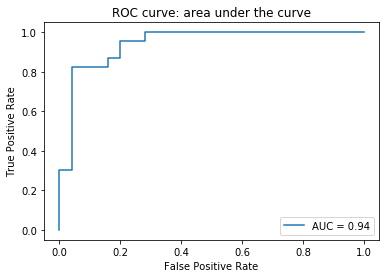

In [15]:

# Probabilities of abel 1 in the test set
probabilities = log_cv.predict_proba(X_test)
y_proba = probabilities[:,1] # probabilities of 1 (bigcoin) in the test tada
print(y_proba)

# ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label = 1)
roc_auc = auc(false_positive_rate, true_positive_rate) # area under the curve

plt.title("ROC curve: area under the curve")
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label = 'AUC = {:0.2}'.format(roc_auc))
plt.legend(loc=0)
plt.plot([0,1], [0,1], ls = '')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

It can be seen that the area under the ROC Curve corresponds to 0.94 this means that there is a 0.94 % chance that the model will be able to distinguish between positive class and negative class.

In [16]:
# Confussion matrix
y_pred_log_cv = log_cv.predict(X_test)
print( classification_report(y_pred_log_cv, y_test) )

              precision    recall  f1-score   support

           0       0.84      0.88      0.86        24
           1       0.87      0.83      0.85        24

    accuracy                           0.85        48
   macro avg       0.85      0.85      0.85        48
weighted avg       0.85      0.85      0.85        48



As we already know the accuracy value corresponds to 0.85, what indicates the proportion of predictions that the model classifies correctly. With the results of the confusion matrix can be calculated also a precision value of 0.87, this is the proportion of actually corrected positive identifications (proportion of target signatures correct classifications); a recall value of 0.83, proportion of actual positives identified correctly.

At this point we have achieved our goal of developing and training a model for signature detection purposes. As this was a first step exercise, there are alot of improvements and work ahead: increasing the number of images is a necessity to improve performance, keep on hyperparameter tuning to reduce the overfitting problems detected and also trying more complex models as neuronal networks are mandatory steps in the future of the project. We also didn’t approach the deployment step, a final stage where we push the machine learning algorithm to a production environment. We expect to keep on these issues in future posts.

References:

https://towardsdatascience.com/classification-of-signature-and-text-images-using-cnn-and-deploying-the-model-on-google-cloud-ml-30bf6f4e3207

https://www.researchgate.net/publication/335807670_Machine_Learning_Approach_for_Signature_Recognition_by_HARRIS_and_SURF_Features_Detector

https://link.springer.com/chapter/10.1007/978-3-540-76280-5_15

https://towardsdatascience.com/understanding-the-confusion-matrix-and-how-to-implement-it-in-python-319202e0fe4d
